# Pipeline for image size estimation

Imports

In [1]:
import os
from pathlib import Path
import cv2
import json
import matplotlib.pyplot as plt
import random
import numpy as np
from segment_anything import sam_model_registry, SamPredictor

## Step 1: Load image data from json

In [2]:
# path to json file
json_file = 'im_coords.json'

# folder containing images
image_folder = 'sample_data'

# load data
with open(json_file, 'r') as file:
    image_data = json.load(file)

Some helper functions for displaying images

In [3]:
# function to show mask
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

# function to show input point
def show_point(x, y, ax):
    ax.scatter([x], [y], color='red', marker='*', s=200, edgecolor='white', linewidth=1.25)

### let's visualize labels from json

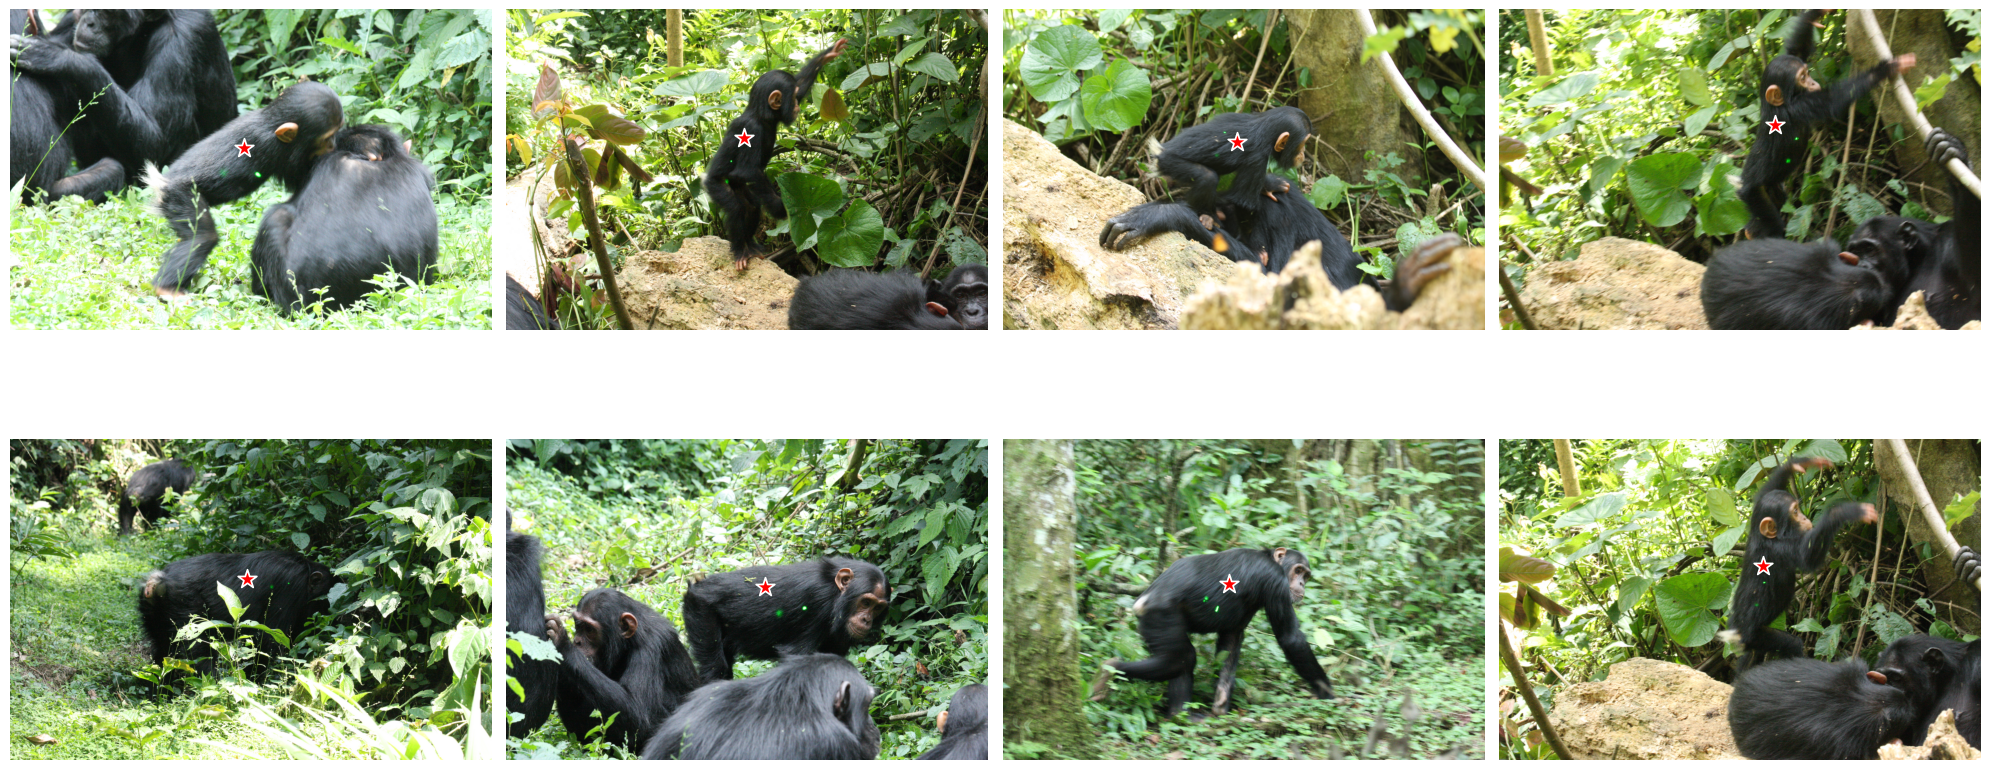

In [4]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# flatten axes for easy indexing
axs = axs.flatten()

idx = 0
# iterate through each entry in json
for image_name, coords in image_data.items():
    image_path = os.path.join(image_folder, image_name)
    # load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting

    if img is not None:
        # extract coordinates
        x, y = coords['x'], coords['y']

        # plot image
        axs[idx].imshow(img)
        show_point(x, y, axs[idx])
        axs[idx].axis('off')

        idx += 1
    else:
        print(f"Could not load image: {image_name}")

plt.tight_layout()
plt.show()

Looks good!

## Step 2: Run images through SAM to prep for laser detection

### ***only need to run this code once to get masks!!!

Set up SAM

In [18]:
# select checkpoint and model type
sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"

# define predictor
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)

In [20]:
def generate_mask(im, x, y):
    input_point = np.array([[x, y]])
    input_label = np.array([1])
    predictor.set_image(im)
    masks, scores, _ = predictor.predict(point_coords=input_point, point_labels=input_label, multimask_output=True)
    # return best mask
    return masks[np.argmax(scores)]

Iterate through images and get mask

In [5]:
# paths
mask_folder = 'sample_data_masks'
updated_json_file = 'im_coords_masks.json'

# Ensure mask folder exists
os.makedirs(mask_folder, exist_ok=True)

In [26]:
# iterate through each entry in the JSON data
for image_name, coords in image_data.items():
    image_path = os.path.join(image_folder, image_name)
    
    # Load the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if img is not None:
        # extract coordinates
        x, y = coords['x'], coords['y']
        # Generate the mask
        mask = generate_mask(img, x, y)
        mask = mask.astype(np.uint8)
        
        # Define the mask filename
        mask_filename = os.path.splitext(image_name)[0] + "_mask.png"
        mask_path = os.path.join(mask_folder, mask_filename)
        
        # Save the mask
        cv2.imwrite(mask_path, mask)
        
        # Update the JSON data with the mask filename
        image_data[image_name]['mask'] = mask_filename

# Write the updated JSON data to a file
with open(updated_json_file, 'w') as file:
    json.dump(image_data, file, indent=4)

print(f"Updated data saved to {updated_json_file}")

Updated data saved to im_coords_masks.json


### let's checkout the results

In [7]:
# Load the JSON data
with open(updated_json_file, 'r') as up_file:
    image_data_masks = json.load(up_file)


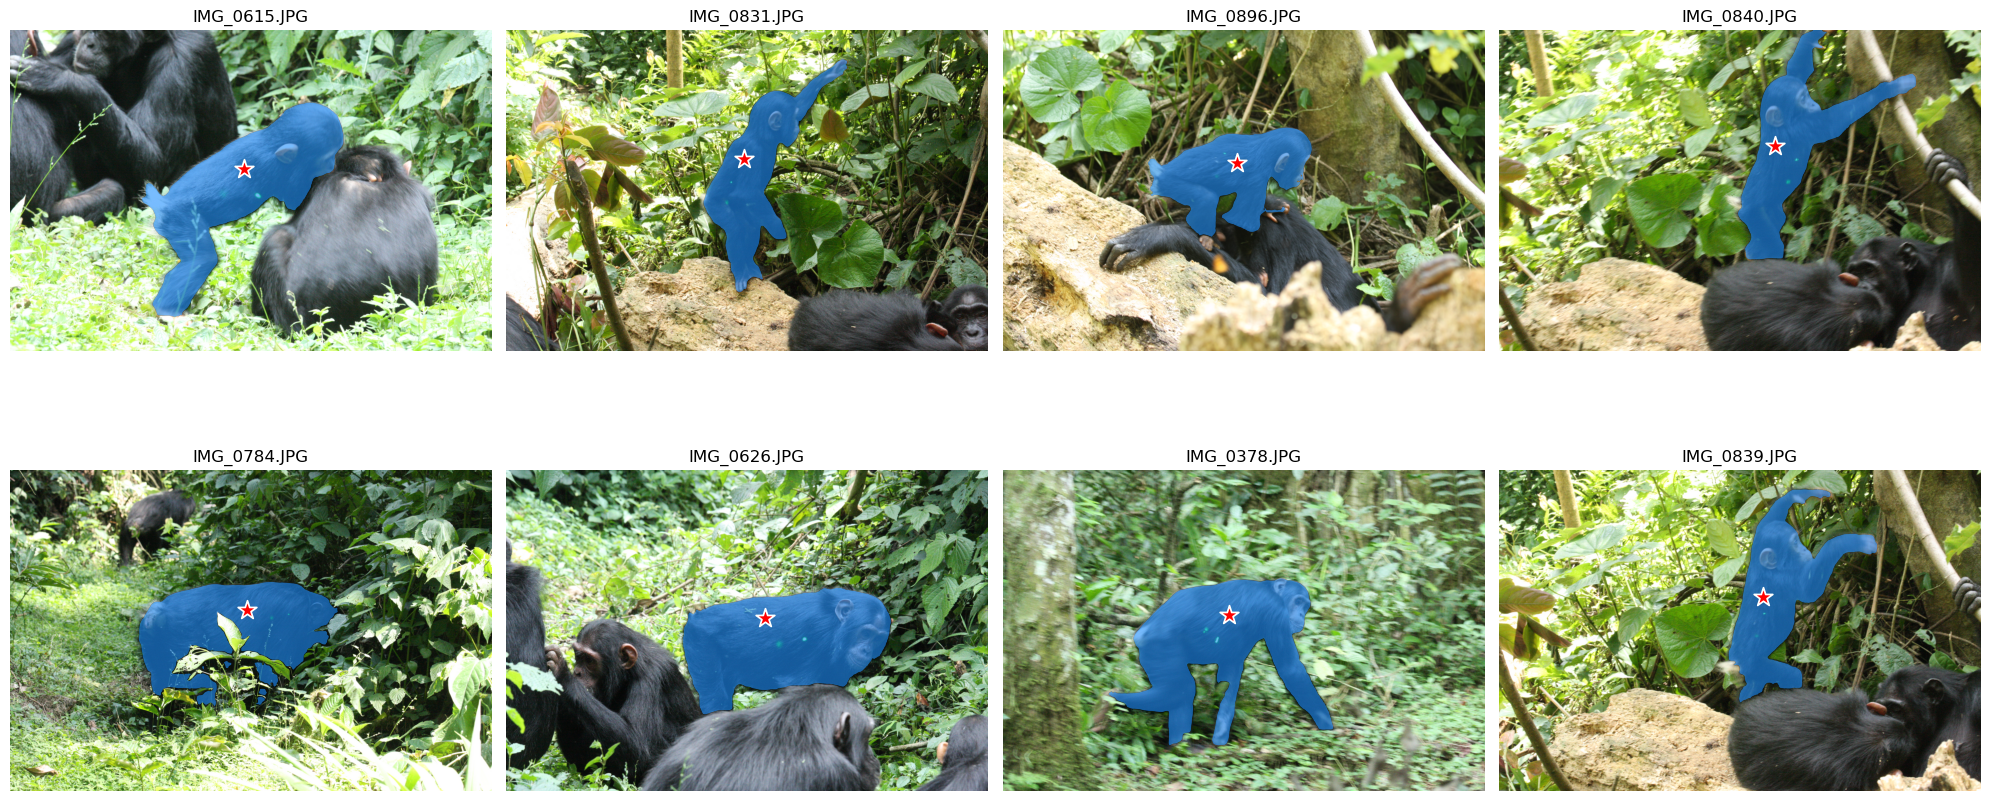

In [11]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# flatten axes for easy indexing
axs = axs.flatten()

idx = 0
# iterate through each entry in json
for image_name, info in image_data_masks.items():
    image_path = os.path.join(image_folder, image_name)
    # load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting

    # Load the mask
    mask_filename = info['mask']
    mask_path = os.path.join(mask_folder, mask_filename)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask in grayscale

    if img is not None:
        # extract coordinates
        x, y = info['x'], info['y']

        # plot image
        axs[idx].imshow(img)
        show_point(x, y, axs[idx])
        show_mask(mask, axs[idx])
        axs[idx].axis('off')
        axs[idx].set_title(image_name)

        idx += 1
    else:
        print(f"Could not load image: {image_name}")

plt.tight_layout()
plt.show()

Good stuff

## Step 3: laser point detection